# Continuous NMR analysis

## Task Summary

#### Measure $\gamma$ for protons
1. Import measurements of frequency and magnetic field taken multiple times (5-10) in order to establish uncertainty of individual measurements.  
2. Calculate the mean and standard deviation of each set of measurements.  Also calculate the percent uncetainty in each set. Use these results to establish uncertainties on the rest of the data points.
3. Import measurements of the resonant frequency $f_{\rm res}$ vs. static field $B_0$ for protons in water (+CuSO<sub>4</sub>) across the range of frequencies available with the oscillator.  
4. Include the uncertainty calculated in step 2.
5. Make a line fit and a plot of the data with the fit (use LMfit) to get the slope of $f_{\rm res}$ versus $B_0$.
6. Calculate $\gamma$ and the $g$-factor for the proton, including uncertainty.

#### Measure the resonance of <sup>19</sup>F versus <sup>1</sup>H
1. Import measurements listing measured B-field along with resonant frequencies of <sup>1</sup>H and <sup>19</sup>F at those field strengths.
2. Fit a line to the resonant frequency of <sup>19</sup>F versus resonant frequency of <sup>1</sup>H from the above data set, plot it (use LMfit) and obtain slope and its uncertainty.
3. From the results calculate $\gamma$ and associated $g$-factor for <sup>19</sup>F from the fit result and the accepted values known for <sup>1</sup>H.
4. Comment in your Group Notebook on the topic of observable chemical shift for fluorine

#### Trend of $T_2^*$ with paramagnetic ion concentration
If you can get quantitative values for how $T_2^*$ decays for a range of concentration, make a plot to see the trend.


In [18]:
# Usually import packages via a handle to the functions in them using import ... as ...
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import uncertainties as unc
import scipy.constants as const
%matplotlib inline

In [19]:
# Useful plot default
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 12 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font

## Magnetic moment of the proton

### Read in the multi-measurement data

You should have a spreadsheet (CSV) with columns or rows of like measurements of frequency and field for a set of steady fields (at least 3 sets of 10 across the range of useable oscillator frequencies).  Import these data with Pandas `pd.read_csv()`:
    
    multi_data = pd.read_csv('multi-measurement_NMR_data.csv')


In [20]:
exercise_1_path = './data/exercise1.csv'
exercise_one_df = pd.read_csv(exercise_1_path)

exercise_one_df_fitlered = exercise_one_df[['Field strength (kG)', 'Resonant Frequency (MHz)']]



In [21]:
exercise_one_df_fitlered.shape

(38, 2)

In [22]:
multiple_readings = exercise_one_df_fitlered.groupby("Field strength (kG)").filter(
    lambda x: x["Field strength (kG)"].shape[0] > 1
)
field_strength_list = list(multiple_readings["Field strength (kG)"].unique())

In [23]:
dict_list = []
for field_strength in field_strength_list:
  data_dict = {}
  data_dict['Field strength (kG)'] = field_strength
  data = multiple_readings[multiple_readings['Field strength (kG)'] == field_strength]
  data_dict['mean'] = data['Resonant Frequency (MHz)'].mean()
  data_dict['Standard Deviation'] = data['Resonant Frequency (MHz)'].std()
  dict_list.append(data_dict)

In [24]:
field_strength_statistics_df = pd.DataFrame(dict_list)
field_strength_statistics_df.head()

,Field strength (kG),mean,Standard Deviation
0,1.90,8.172168,0.000467
1,2.25,9.664800,0.001311
2,2.60,11.161019,0.000850


If the multiple measurements in the dataframe `df` are in a column with name `'col_name'` you an calculat the mean and standard deviation with the internal methods like this:

    col_mean = df['col_name'].mean()
    col_std_dev = df['col_name'].std()
    
Then the percent uncertainty is just the ratio of the standard deviation to the mean ($\times$100).  Calculate this too.

In [25]:
field_strength_statistics_df['Percent Uncertainty'] = (field_strength_statistics_df['Standard Deviation'] /field_strength_statistics_df['mean']) * 100
field_strength_statistics_df.head()


,Field strength (kG),mean,Standard Deviation,Percent Uncertainty
0,1.90,8.172168,0.000467,0.005714
1,2.25,9.664800,0.001311,0.013561
2,2.60,11.161019,0.000850,0.007613


If the standard deviations are (nearly) the same, you can use one number for the uncertainty in a frequency or field measurement.  If they are different, check the percent uncertainty.  If these are (nearly) the same, then the data-point uncertainty can be given by the value times this percent uncertainty. If these are different, then you should use an interpolation function to calculate the uncertainty in a data point.

The Python libraries provide just such a function: the **SciPy** `interpolate` package, which you can read about here: [SciPy Interpolate](https://docs.scipy.org/doc/scipy/reference/reference/interpolate.html).

The SciPy function to use is `interp1d()`.  Notice that it creates a *function*. To create the interpolation function, you feed it your feed it your list of uncertainties versus frequency or uncertainties versus field, then use the result with your array of values of $f_{\rm res}$ versus $B_0$ to obtain the uncertainty for each data point.

In [26]:
# Make a table of the uncertainty calculation to easily compare the values across the measurement range.


# Apply the largest percent uncertainty to all values
max_percent_uncertainty = field_strength_statistics_df['Percent Uncertainty'].max()

exercise_one_df_fitlered['Percent Uncertainty'] = max_percent_uncertainty


/var/folders/vm/mvlb1j8s3l5_6rj24gvmyxxh0000gn/T/ipykernel_71553/3246121719.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exercise_one_df_fitlered['Percent Uncertainty'] = max_percent_uncertainty


### Read in the resonance data for protons

Use `read_csv()` as before.  You should have a table with at least 2 columns: resonance frequency and magnetic field.

Print a table.

In [ ]:
single_readings = exercise_one_df_fitlered.groupby("Field strength (kG)").filter(
    lambda x: x["Field strength (kG)"].shape[0] == 1
)

field_strength_statistics_df = field_strength_statistics_df.drop(
    columns=["Standard Deviation"]
)
field_strength_statistics_df = field_strength_statistics_df.rename(
    columns={
        "Field strength (kG)": "Field strength (kG)",
        "mean": "Resonant Frequency (MHz)",
        "Percent Uncertainty": "Percent Uncertainty",
    }
)

proton_resonance_df = pd.concat([single_readings, field_strength_statistics_df])

proton_resonance_df = proton_resonance_df.sort_values(
    by="Field strength (kG)"
).reset_index(drop=True)

proton_resonance_df["Percent Uncertainty"] = max_percent_uncertainty

print(proton_resonance_df)

    Field strength (kG)  Resonant Frequency (MHz)  Percent Uncertainty
0                 1.900                  8.172168             0.013561
1                 1.970                  8.476610             0.013561
2                 2.040                  8.772190             0.013561
3                 2.111                  9.083190             0.013561
4                 2.180                  9.373600             0.013561
5                 2.250                  9.664800             0.013561
6                 2.320                  9.971280             0.013561
7                 2.391                 10.270540             0.013561
8                 2.460                 10.571280             0.013561
9                 2.530                 10.868310             0.013561
10                2.600                 11.161019             0.013561


In [41]:
proton_resonance_df["Resonant Frequency (MHz)"]

0      8.172168
1      8.476610
2      8.772190
3      9.083190
4      9.373600
5      9.664800
6      9.971280
7     10.270540
8     10.571280
9     10.868310
10    11.161019
Name: Resonant Frequency (MHz), dtype: float64

In [28]:
# Based on the result of the uncertainty analysis above, construct uncertainty arrays
# to go with the data according to those instructions.

# Include the uncertainty results as another column in the dataframe


### Fit the data to extract the slope

Use LMfit.  See the examples.

In [29]:
from lmfit.models import LinearModel

line = LinearModel()


In [30]:
x_data = proton_resonance_df["Field strength (kG)"]
y_data = proton_resonance_df["Resonant Frequency (MHz)"]

start_params = line.guess(y_data, x=x_data)

Line_fit = line.fit(y_data, start_params, x=x_data)

Line_fit

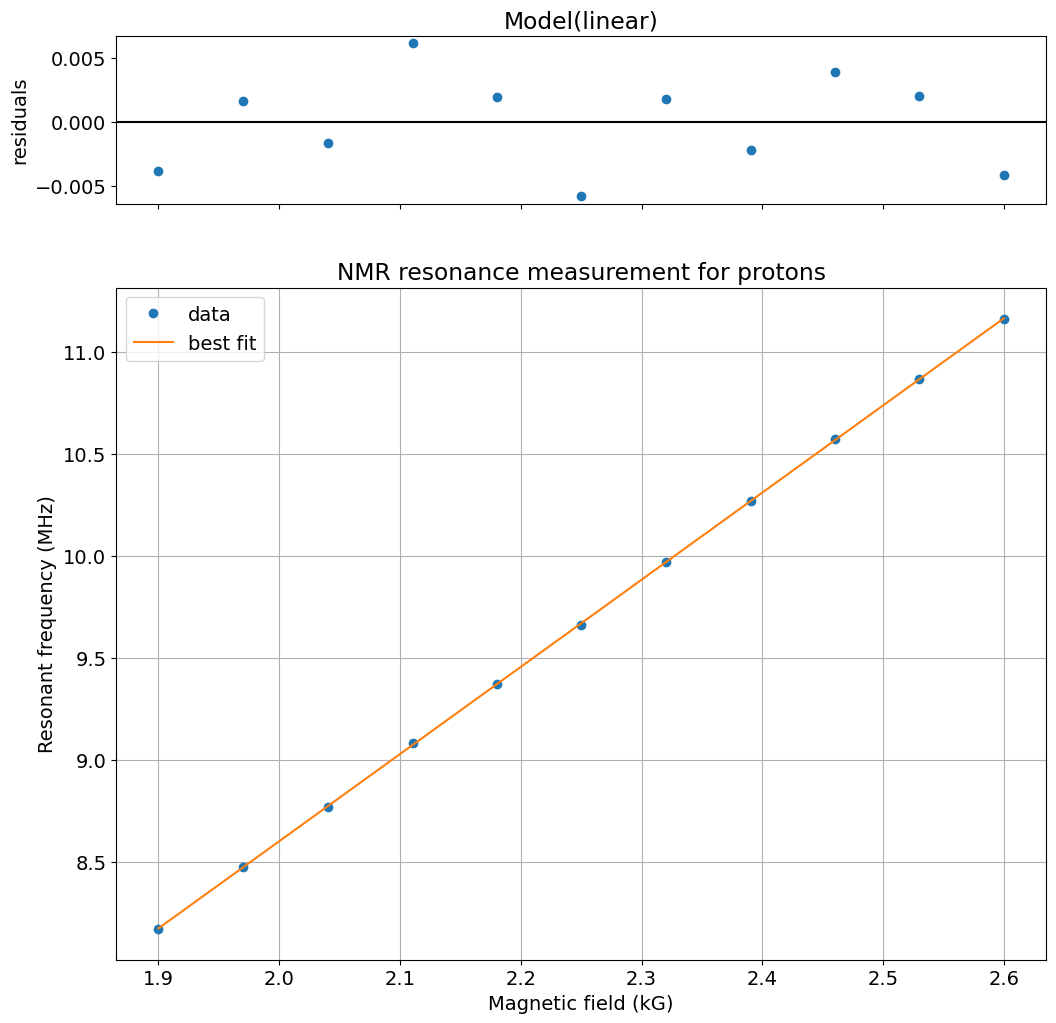

In [31]:
# Make a plot.  Example
Line_fit.plot()
plt.grid(True)
plt.title('NMR resonance measurement for protons')
plt.xlabel('Magnetic field (kG)')
plt.ylabel('Resonant frequency (MHz)');

### Extract the slope with uncertainty from the fit parameters


In [36]:
proton_slope = unc.ufloat(
    Line_fit.params["slope"].value, Line_fit.params["slope"].stderr, "proton_slope"
)
print("gamma for protons = {:.2uP} MHz/kG".format(proton_slope))

gamma for protons = 4.2702±0.0054 MHz/kG


Calculate $\gamma$ in rad/(s-T) to compare to accepted values.  Use the conversion constants in `scipy.constants`


In [40]:
expected_gamma = const.value("nuclear magneton in MHz/T") * const.value(
    "proton g factor"
)
# print('Expected value of gamma for proton: {:.6g} MHz/T'.format(expected_gamma))
expected_gamma_rad = expected_gamma * 2 * np.pi * 1e6
print(f"{expected_gamma_rad:e}")


gamma_rad = proton_slope * 2 * np.pi * 1e7

print(f"Experimental value for Gamma for protons: {gamma_rad} rad/(s-T)")

2.675222e+08
Experimental value for Gamma for protons: (2.6831+/-0.0034)e+08 rad/(s-T)


Calculate the proton $g$-factor from your result and compare to the expected value.

In [ ]:
g_experimental = (2 * gamma_rad * const.value("proton mass")) / (
    const.value("elementary charge")
)

print(f"The experimental value of our g factor is: {g_experimental}")

print(f"The expected value of the g factor is: {const.value('proton g factor')}")

The experimental value of our g factor is: 5.602+/-0.007
The expected value of the g factor is: 5.5856946893


## Fluorine-19 versus Proton (Hydrogen-1) resonance

### Read in the data

Also, print a table.

In [35]:
# Use pd.read_csv(), as you did earlier

flourine_proton_data_path = './cwnmr_data/Data - Exercise3.csv'

florine_proton_df = pd.read_csv(flourine_proton_data_path)



FileNotFoundError: [Errno 2] No such file or directory: './cwnmr_data/Data - Exercise3.csv'

In [ ]:
florine_proton_df.head(5)


,B Field (kG),Copper Sulfate resonant frequency (MHz),Flourine resonant frequency (MHz),Teflon resonant frequency (MHz),29
0,1.900,8.17787,7.69388,7.69715,NaN
1,2.075,8.96246,8.39772,8.39763,NaN
2,2.250,9.67619,9.10343,9.10370,NaN
3,2.425,10.42534,9.80704,9.80542,NaN
4,2.600,11.17449,10.51274,10.51380,NaN


### Plot and fit the data.  

BUT: Here you are comparing the resonant frequencies only!  The magnetic field measurement does not matter, as long as it is stable between the two frequency measurements for each data point

In [ ]:
# Make a fit and plot of fluorine resonant frequency versus hydrogen resonant frequency.

# proton on x axis flourine on y axis



# Get starting parameters.  Example:
x_data = florine_proton_df['Copper Sulfate resonant frequency (MHz)']
y_data = florine_proton_df['Flourine resonant frequency (MHz)']

start_params = line.guess(y_data, x=x_data)

# Feed these into the fitter and run it. Example:
# Line_fit = line.fit(y_data, start_params, x=x_data, weights=1/y_data_unc)
Line_fit = line.fit(y_data, start_params, x=x_data)


# Print the fit results. Example
Line_fit



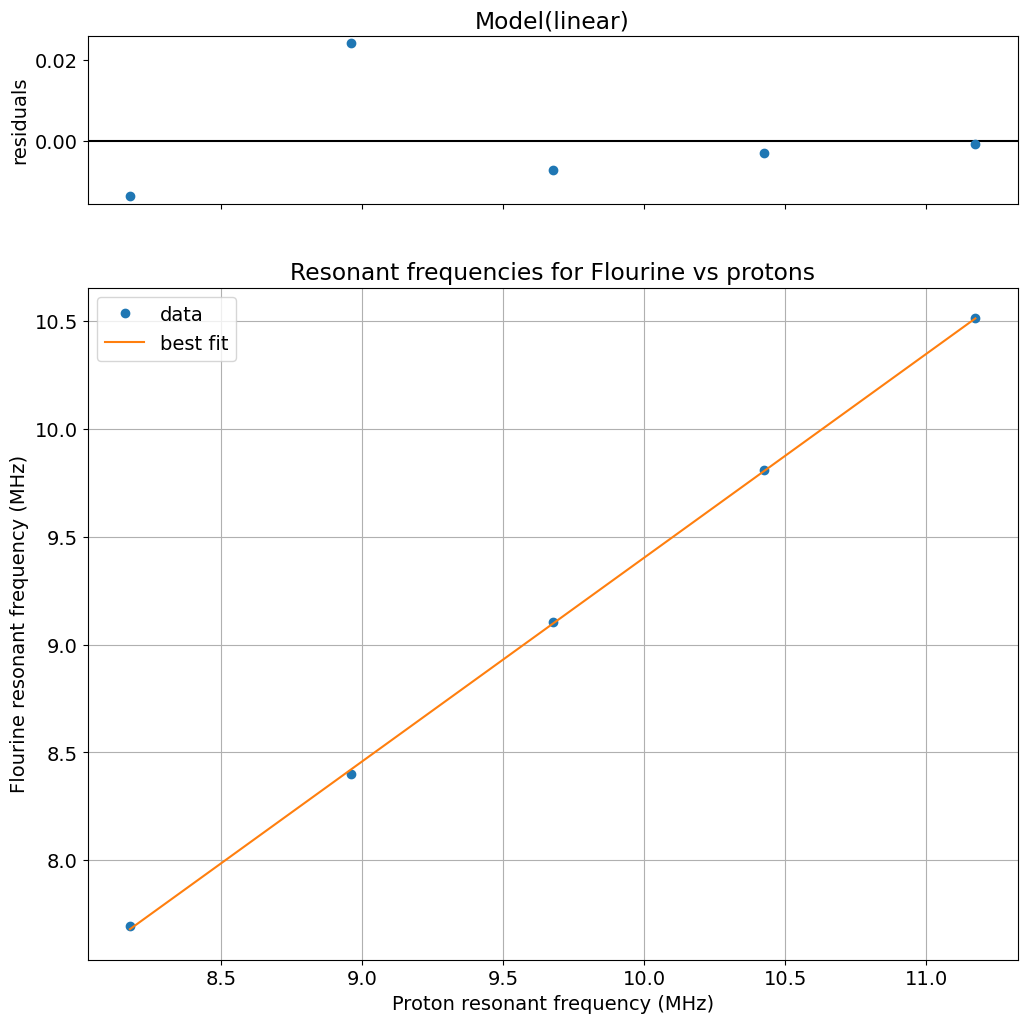

In [ ]:
# Make a plot.  Example
Line_fit.plot()
plt.grid(True)
plt.title('Resonant frequencies for Flourine vs protons')
plt.xlabel('Proton resonant frequency (MHz)')
plt.ylabel('Flourine resonant frequency (MHz)');


### Use the result

Obtain the slope with uncertainty and with the result calculate a value for $\gamma_F$ and the <sup>19</sup>F $g$-factor.

In [ ]:
proton_flourine_slope = unc.ufloat(Line_fit.params['slope'].value, Line_fit.params['slope'].stderr,'proton_flourine_slope')
print(f'Flourine vs proton slope: {proton_flourine_slope}')
gamma_f=expected_gamma_rad*proton_flourine_slope
print("flourine gamma:",gamma_f)
g=const.value("proton g factor")*proton_flourine_slope
print("flourine g:",g)

Flourine vs proton slope: 0.945+/-0.007
flourine gamma: (2.528+/-0.019)e+08
flourine g: 5.28+/-0.04


## Trend of $T_2^*$ as a function of paramagnetic ion concentration

From the scope screen images, extract estimates of the relaxation time $T_2^*$ as a function of concentration of the copper sulfate ions.  

Plot these on a plot with double-log axes.  To change the axis type of a plot use the functions

    plt.xscale('log')
    plt.yscale('log')
    
You should see a trend that the relaxation time gets a bit longer and then levels out as the concentration is decreased.

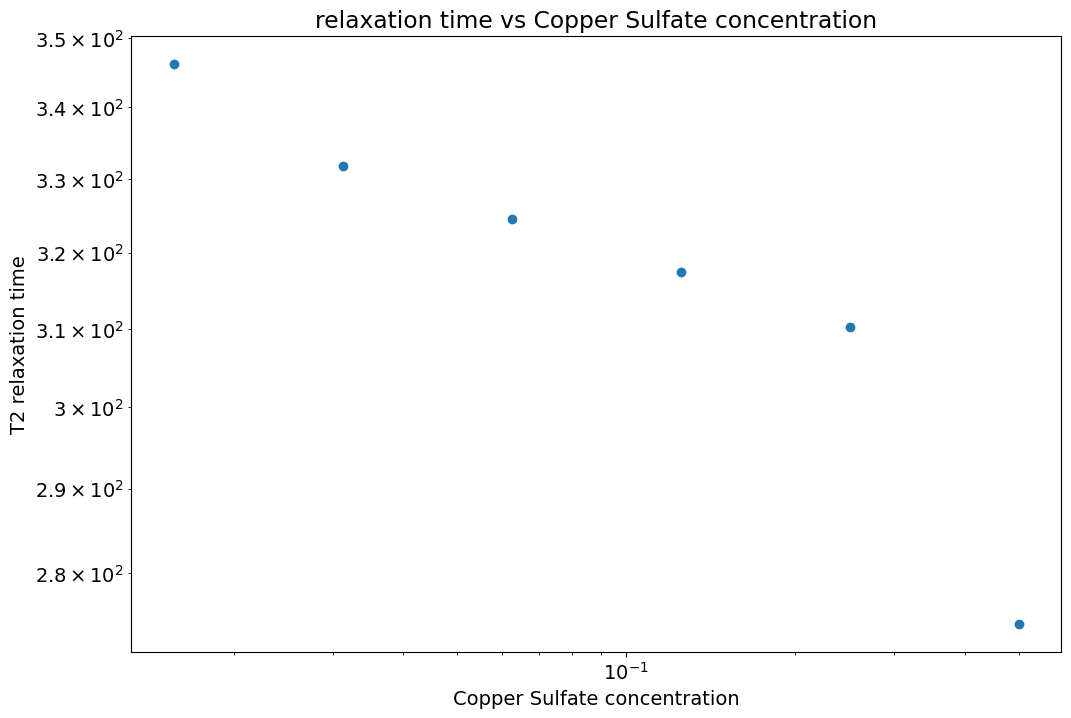

In [ ]:
# You code this





concentrations = [1/2, 1/4, 1/8, 1/16, 1/32, 1/64]
T2_datapoints = [274.11, 310.18, 317.392909, 324.6063842, 331.8198594, 346.2468098]


plt.xscale('log')
plt.yscale('log')

plt.xlabel('Copper Sulfate concentration')
plt.ylabel('T2 relaxation time')
plt.title('relaxation time vs Copper Sulfate concentration')
plt.scatter(concentrations, T2_datapoints)

